# Metodologia para Avaliação de Overhead em HPC usando DGEMM no Docker

Este _notebook_ organiza a metodologia para quantificar o _overhead_ (sobrecarga), introduzido pelo uso de containers Docker, na execução de aplicações de alto desempenho. Com esta finalidade é utilizada uma aplicação baseadas na operação DGEMM, comparando o desempenho de sua exeução no container com a execução nativa no sistema operacional.

## 1. Introdução

O objetivo deste estudo é quantificar o _overhead_ introduzido pelo Docker em aplicações de alto desempenho, usando como base um benchmark de DGEMM. São consideradas diferentes combinações de:

- Implementações de BLAS (por exemplo, OpenBLAS, BLIS)
- Implementação sequencial e com multiplas _threads_
- Tamanhos de matrizes
- Execução em ambiente **nativo** vs. **Docker**

As métricas coletadas em cada execução são:

- Tempo de execução
- Desempenho em FLOPS ou GFLOPS (Operações de ponto flutuante por segundo)

A partir dessas métricas, serão definidas expressões para calcular o _overhead_ em termos de tempo e desempenho, bem como procedimentos estatísticos para garantir robustez na análise.


In [48]:
# Carregar e inspecionar dados brutos
import pandas as pd
import numpy as np
import sys
from pathlib import Path

# Adicionar caminho do script de análise
sys.path.append('..')
from analysis_benchmark_hpc import load_data, calculate_overhead, calculate_gflops

# Configuração
base_path = '../output'
threading_mode = 'single'  # single-thread
run_number = '001'

# Variantes BLAS para análise
variants = ['OpenBLAS64', 'BLIS64']
environments = ['native', 'docker']
methods = ['alternatives', 'direct_compilation']

# Carregar dados de todas as combinações
all_data = []
for variant in variants:
    for env in environments:
        for method in methods:
            df = load_data(base_path, threading_mode, env, method, variant, run_number)
            if df is not None:
                df['variant'] = variant
                df['environment'] = env
                df['method'] = method
                all_data.append(df)

# Combinar todos os dados
if all_data:
    df_combined = pd.concat(all_data, ignore_index=True)
    print(f'Total de registros carregados: {len(df_combined)}')
    print(f'Colunas disponíveis: {list(df_combined.columns)}')
    print('\nPrimeiras 20 linhas:')
    df_combined.head(20)
else:
    print("AVISO: Nenhum dado foi carregado. Verifique os caminhos e arquivos de saída.")
    # Criar DataFrame vazio para evitar erros subsequentes
    df_combined = pd.DataFrame(columns=['matSize', 'Size', 'Mean', 'Variance', 'Largest', 'Smallest', 'Median', 'SD', 'SD_Mean', 'Skew', 'RMS', 'Kurtosis', 'variant', 'environment', 'method'])


Total de registros carregados: 1024
Colunas disponíveis: ['matSize', 'Size', 'Mean', 'Variance', 'Largest', 'Smallest', 'Median', 'SD', 'SD_Mean', 'Skew', 'RMS', 'Kurtosis', 'variant', 'environment', 'method']

Primeiras 20 linhas:


## 2. Desenho Experimental

Os experimentos são organizados conforme os seguintes fatores:

### 2.1 Ambientes comparados
- Execução **nativa** no sistema operacional (host).
- Execução **em container Docker**, mantendo o máximo de equivalência possível:
  - Mesma implementação de BLAS
  - Mesmo compilador e flags de compilação
  - Mesma versão do benchmark

### 2.2 Fatores de variação
- Implementações BLAS: OpenBLAS, BLIS, etc.
- Tamanhos de matriz: 32, 64, ..., 4096, aumentando o tamanho de 32 em 32

### 2.3 Repetições
Para cada combinação de parâmetros (BLAS, número de *threads*, tamanho da matriz, ambiente), o benchmark deve ser executado
múltiplas vezes (por exemplo, \( n = 5 \)), registrando-se o tempo de execução e o desempenho em GFLOPS.

Essas repetições permitem estimar média, desvio padrão, intervalos de confiança e significância estatística das diferenças
entre o ambiente nativo e o Docker.


In [49]:
# Implementar leitura e organização dos resultados experimentais
# Filtrar apenas dados com Mean > 0 para evitar problemas
df_combined_valid = df_combined[df_combined['Mean'] > 0].copy()

if len(df_combined_valid) < len(df_combined):
    print(f"⚠️  Aviso: {len(df_combined) - len(df_combined_valid)} registros com tempo=0 foram excluídos\n")

# Estatísticas descritivas globais
print("="*80)
print("Estatísticas descritivas do tempo médio de execução (dados válidos):")
print("="*80)
stats_desc = df_combined_valid['Mean'].describe()
print(f"\nEstatísticas globais de todos os {len(df_combined_valid)} registros:")
print(stats_desc)

# Estatísticas por ambiente (Native vs Docker)
print("\n" + "-"*80)
print("Estatísticas por Ambiente:")
print("-"*80)
for env in environments:
    env_data = df_combined_valid[df_combined_valid['environment'] == env]['Mean']
    print(f"\n{env.upper()}:")
    print(f"  Contagem: {len(env_data)}")
    print(f"  Média:    {env_data.mean():.6f} s")
    print(f"  Mediana:  {env_data.median():.6f} s")
    print(f"  Desvio:   {env_data.std():.6f} s")
    print(f"  Mínimo:   {env_data.min():.6f} s")
    print(f"  Máximo:   {env_data.max():.6f} s")

# Estatísticas por Variante BLAS
print("\n" + "-"*80)
print("Estatísticas por Variante BLAS:")
print("-"*80)
for variant in variants:
    variant_data = df_combined_valid[df_combined_valid['variant'] == variant]['Mean']
    print(f"\n{variant}:")
    print(f"  Contagem: {len(variant_data)}")
    print(f"  Média:    {variant_data.mean():.6f} s")
    print(f"  Desvio:   {variant_data.std():.6f} s")

print("\n" + "="*80)

⚠️  Aviso: 17 registros com tempo=0 foram excluídos

Estatísticas descritivas do tempo médio de execução (dados válidos):



Estatísticas globais de todos os 1007 registros:
count    1007.000000
mean        0.657620
std         0.736167
min         0.000100
25%         0.048450
50%         0.341200
75%         1.105050
max         2.918900
Name: Mean, dtype: float64

--------------------------------------------------------------------------------
Estatísticas por Ambiente:
--------------------------------------------------------------------------------

NATIVE:
  Contagem: 503
  Média:    0.672762 s
  Mediana:  0.355500 s
  Desvio:   0.751969 s
  Mínimo:   0.000100 s
  Máximo:   2.918900 s

DOCKER:
  Contagem: 504
  Média:    0.642508 s
  Mediana:  0.333000 s
  Desvio:   0.720480 s
  Mínimo:   0.000100 s
  Máximo:   2.766900 s

--------------------------------------------------------------------------------
Estatísticas por Variante BLAS:
--------------------------------------------------------------------------------

OpenBLAS64:
  Contagem: 503
  Média:    0.596542 s
  Desvio:   0.660901 s

BLIS64:
  Cont

## 3. Definição das Métricas de _Overhead_

A avaliação do _overhead_ será feita a partir de duas métricas principais:

- _Overhead_ no tempo de execução
- _Overhead_ no desempenho (GFLOPS)

Para cada configuração $(\text{BLAS}, N)$, serão comparados os resultados nos ambientes **host** (nativo) e **Docker**.

### 3.1 _Overhead_ em tempo de execução

Sejam:

- $( T_{\text{host}} )$: tempo médio de execução no sistema nativo
- $( T_{\text{dock}} )$: tempo médio de execução no Docker

Define-se o _overhead_ em tempo como:

$\text{Overhead}_{\text{tempo}} = \frac{T_{\text{dock}} - T_{\text{host}}}{T_{\text{host}}}$ 

Também é útil definir o fator de *slowdown*:

$ \text{Slowdown} = \frac{T_{\text{dock}}}{T_{\text{host}}}.$

**Interpretação:**
- Valores **positivos**: Docker introduz overhead (mais lento que nativo)
- Valores **negativos**: Docker é mais rápido (improvável, mas possível)
- Valores **próximos de zero**: Desempenho equivalente
- Slowdown > 1: Docker mais lento; Slowdown < 1: Docker mais rápido

### 3.2 _Overhead_ em desempenho (GFLOPS)

Sejam:

- $ P_{\text{host}} $: desempenho médio em GFLOPS no sistema nativo
- $ P_{\text{dock}} $: desempenho médio em GFLOPS no Docker

Define-se o _overhead_ em termos de desempenho como:

$ \text{Overhead}_{\text{GFLOPS}} = \frac{P_{\text{host}} - P_{\text{dock}}}{P_{\text{host}}}.$

Também é útil definir a eficiência computacional:

$ \text{Eficiência} = \frac{P_{\text{dock}}}{P_{\text{host}}}.$

**Interpretação:**
- Valores **positivos**: Docker tem perda de desempenho
- Valores **negativos**: Docker supera o nativo (improvável)
- Valores **próximos de zero**: Desempenho equivalente
- Eficiência ≈ 1.0 (100%): Sem perda de desempenho

In [50]:
# Calcular overhead de tempo e GFLOPS a partir dos dados agregados
# Pivot para comparar native vs docker
if not df_combined.empty:
    df_pivot = df_combined.pivot_table(
        index=['variant', 'method', 'matSize'],
        columns='environment',
        values='Mean',
        aggfunc='first'
    ).reset_index()
else:
    df_pivot = pd.DataFrame(columns=['variant', 'method', 'matSize', 'native', 'docker'])

# Verificação de robustez para dados incompletos
if 'docker' in df_pivot.columns and 'native' in df_pivot.columns:
    # Identificar registros válidos (sem NaN e sem zeros)
    valid_mask = (df_pivot['native'].notna()) & (df_pivot['docker'].notna()) & \
                 (df_pivot['native'] > 0) & (df_pivot['docker'] > 0)
    
    invalid_count = (~valid_mask).sum()
    
    # Fórmula padrão HPC: overhead_tempo = (T_docker - T_native) / T_native
    # Positivo = Docker mais lento (overhead existe)
    # Negativo = Docker mais rápido (improvável)
    df_pivot['overhead_tempo'] = (df_pivot['docker'] - df_pivot['native']) / df_pivot['native']
    
    # Slowdown factor (complementar)
    df_pivot['slowdown'] = df_pivot['docker'] / df_pivot['native']
    
    # Calcular GFLOPS
    df_pivot['gflops_native'] = df_pivot.apply(
        lambda row: calculate_gflops(row['matSize'], row['native']) if row['native'] > 0 else 0, axis=1
    )
    df_pivot['gflops_docker'] = df_pivot.apply(
        lambda row: calculate_gflops(row['matSize'], row['docker']) if row['docker'] > 0 else 0, axis=1
    )
    
    # Overhead de GFLOPS: (GFLOPS_native - GFLOPS_docker) / GFLOPS_native
    # Positivo = Docker tem menos desempenho (perda)
    # Negativo = Docker tem mais desempenho (ganho)
    df_pivot['overhead_gflops'] = (df_pivot['gflops_native'] - df_pivot['gflops_docker']) / df_pivot['gflops_native']
    
    # Eficiência computacional (complementar)
    df_pivot['efficiency'] = df_pivot['gflops_docker'] / df_pivot['gflops_native']
    
    # Verificar quantos registros têm dados completos
    complete_records = valid_mask.sum()
    total_records = len(df_pivot)
    
    print(f"\n📊 Status dos Dados:")
    print(f"   Total de registros: {total_records}")
    print(f"   Registros válidos: {complete_records}")
    if invalid_count > 0:
        print(f"   Registros inválidos: {invalid_count}")
    
    print("\n✓ Overhead calculado com sucesso")
else:
    print("AVISO: Dados de 'docker' ou 'native' não encontrados. O cálculo de overhead será pulado.")
    df_pivot['overhead_tempo'] = 0.0
    df_pivot['slowdown'] = 1.0
    df_pivot['overhead_gflops'] = 0.0
    df_pivot['efficiency'] = 1.0
    df_pivot['gflops_docker'] = 0.0
    df_pivot['gflops_native'] = 0.0



📊 Status dos Dados:
   Total de registros: 512
   Registros válidos: 503
   Registros inválidos: 9

✓ Overhead calculado com sucesso


## 4. Tratamento Estatístico

Para cada combinação de parâmetros e ambiente, será feita uma análise estatística básica dos resultados,
incluindo cálculo de médias, desvios padrão, intervalos de confiança e testes de significância.

### 4.1 Cálculo de média e variabilidade

Sejam $ x_1, x_2, \ldots, x_n $ as observações (por exemplo, tempos de execução de $ n $ repetições).

A média amostral é dada por:

$ \overline{x} = \frac{1}{n} \sum_{i=1}^{n} x_i,$

e o desvio padrão amostral é:

$ \sigma = \sqrt{ \frac{1}{n-1} \sum_{i=1}^{n} (x_i - \overline{x})^2 }. $

Essas quantidades podem ser calculadas tanto para tempo de execução quanto para GFLOPS, em cada ambiente.

### 4.2 Intervalos de confiança (opcional)

Supondo distribuição aproximadamente normal das médias, um intervalo de confiança de 95% para a média pode ser escrito como:

$ IC = \overline{x} \pm t_{\alpha/2} \cdot \frac{\sigma}{\sqrt{n}}, $

onde $ t_{\alpha/2} $ é o valor crítico da distribuição t de Student.

### 4.3 Testes de significância

Para verificar se as diferenças entre host e Docker são estatisticamente significativas, podem ser utilizados:

- Teste t pareado (se as suposições de normalidade forem razoáveis)
- Testes não-paramétricos, como Wilcoxon, se necessário

Essa análise ajuda a distinguir diferenças reais de flutuações devido a ruído ou variabilidade do sistema.


In [51]:
# Importar scipy.stats para testes estatísticos
from scipy import stats

if 'docker' in df_combined['environment'].unique():
    # Testes de hipótese: teste t pareado
    print("\nTestes de Significância (Native vs Docker):")
    for variant in variants:
        for method in methods:
            mask = (df_combined['variant'] == variant) & (df_combined['method'] == method)
            native_data = df_combined[mask & (df_combined['environment'] == 'native')].sort_values('matSize')
            docker_data = df_combined[mask & (df_combined['environment'] == 'docker')].sort_values('matSize')

            native_times = native_data['Mean'].values
            docker_times = docker_data['Mean'].values

            if len(native_times) > 1 and len(docker_times) > 1 and len(native_times) == len(docker_times):
                t_stat, p_value = stats.ttest_rel(native_times, docker_times)
                significant = "Sim (p<0.05)" if p_value < 0.05 else "Não"
                print(f"{variant:<15} {method:<20} t={t_stat:8.4f}, p={p_value:8.6f} - Significativo: {significant}")

else:
    print("AVISO: Dados de 'docker' não encontrados. Testes estatísticos pulados.")


Testes de Significância (Native vs Docker):
OpenBLAS64      alternatives         t=  9.6551, p=0.000000 - Significativo: Sim (p<0.05)
OpenBLAS64      direct_compilation   t=  9.5785, p=0.000000 - Significativo: Sim (p<0.05)
BLIS64          alternatives         t=  9.3393, p=0.000000 - Significativo: Sim (p<0.05)
BLIS64          direct_compilation   t=  9.1968, p=0.000000 - Significativo: Sim (p<0.05)


## 5. Apresentação dos Resultados

### 5.1 Tabelas sugeridas

Uma forma clara de apresentar os resultados é usar tabelas que agreguem as métricas principais para cada combinação de parâmetros.
Por exemplo:

| BLAS | Threads | N | $T_{\text{host}}$ | $T_{\text{dock}}$ | Overhead tempo (%) | $P_{\text{host}}$ | $P_{\text{dock}}$ | Overhead GFLOPS (%) |
|------|---------|---|--------------------|--------------------|--------------------|--------------------|--------------------|----------------------|
| ...  |   ...   |...|        ...         |        ...         |        ...         |        ...         |        ...         |         ...          |

### 5.2 Gráficos sugeridos

Alguns gráficos que ajudam a visualizar o comportamento do overhead:

- Overhead de tempo (%) em função do tamanho da matriz \( N \)
- Overhead de tempo (%) em função do número de *threads*
- Comparação do overhead entre diferentes implementações de BLAS

Esses gráficos podem ser construídos tanto para tempo quanto para GFLOPS.



📊 Dados válidos para análise: 503 de 512 registros

ESTATÍSTICAS DE OVERHEAD

Alternatives - OpenBLAS64:
  Overhead Tempo:  Média = -0.044696 (-4.470%), Desvio = 0.034238 (3.424%)
  Slowdown Factor: Média = 0.955304x
  Overhead GFLOPS: Média = -0.048516 (-4.852%), Desvio = 0.049037 (4.904%)
  Eficiência:      Média = 1.048516 (104.85%)

Alternatives - BLIS64:
  Overhead Tempo:  Média = -0.033365 (-3.337%), Desvio = 0.098710 (9.871%)
  Slowdown Factor: Média = 0.966635x
  Overhead GFLOPS: Média = -0.040720 (-4.072%), Desvio = 0.067220 (6.722%)
  Eficiência:      Média = 1.040720 (104.07%)

Compilação Direta - OpenBLAS64:
  Overhead Tempo:  Média = -0.048313 (-4.831%), Desvio = 0.030841 (3.084%)
  Slowdown Factor: Média = 0.951687x
  Overhead GFLOPS: Média = -0.051896 (-5.190%), Desvio = 0.035289 (3.529%)
  Eficiência:      Média = 1.051896 (105.19%)

Compilação Direta - BLIS64:
  Overhead Tempo:  Média = +0.183156 (+18.316%), Desvio = 2.588985 (258.899%)
  Slowdown Factor: Média = 1.18

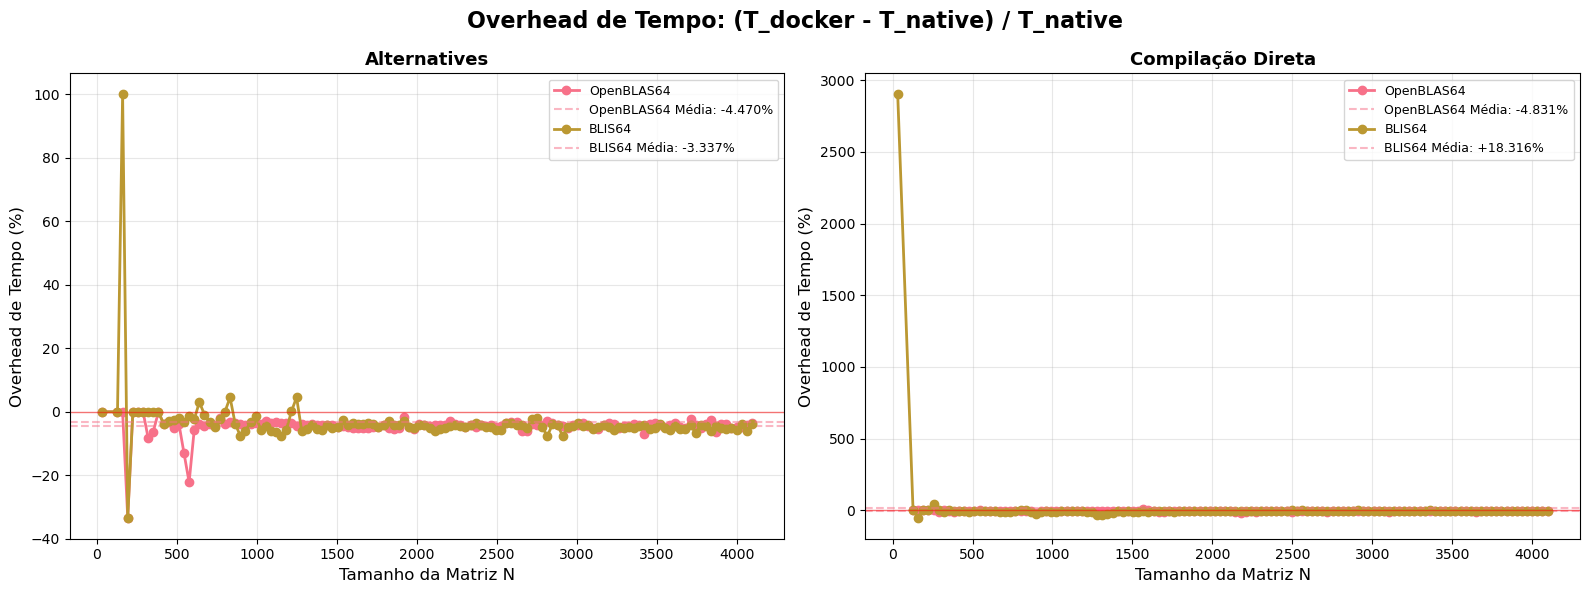

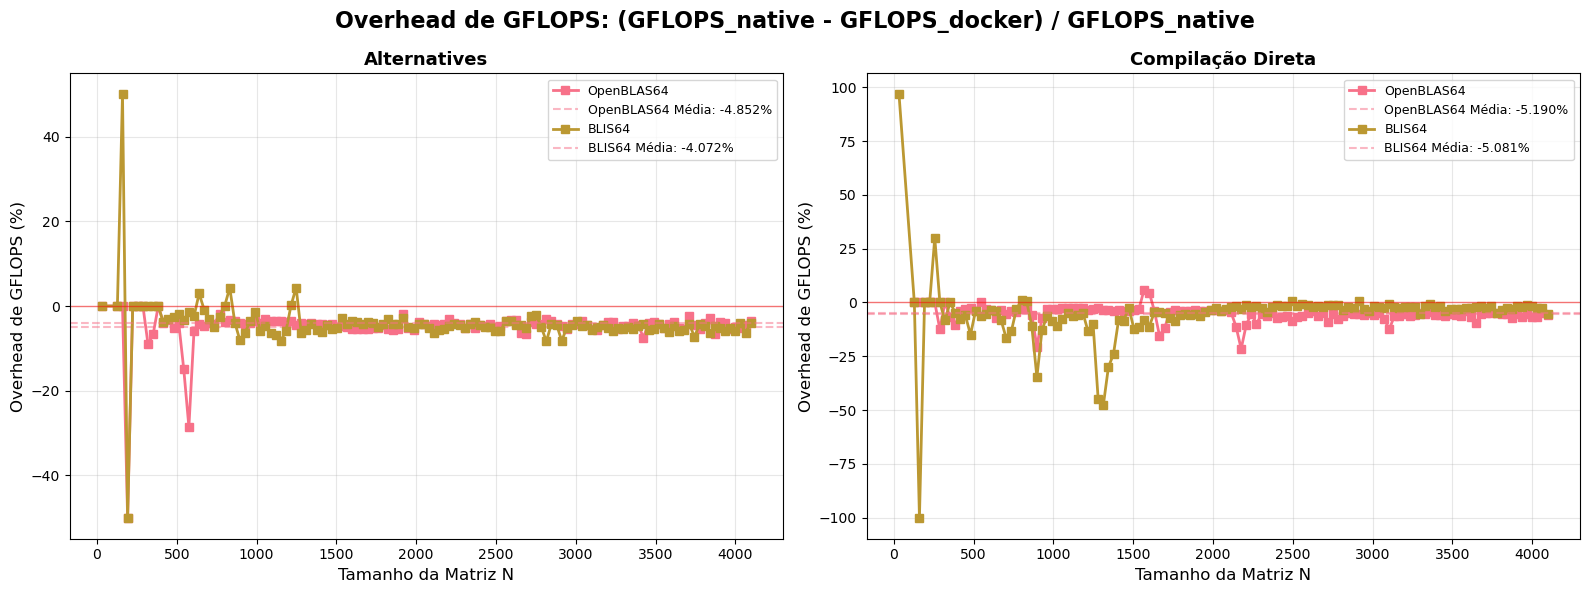

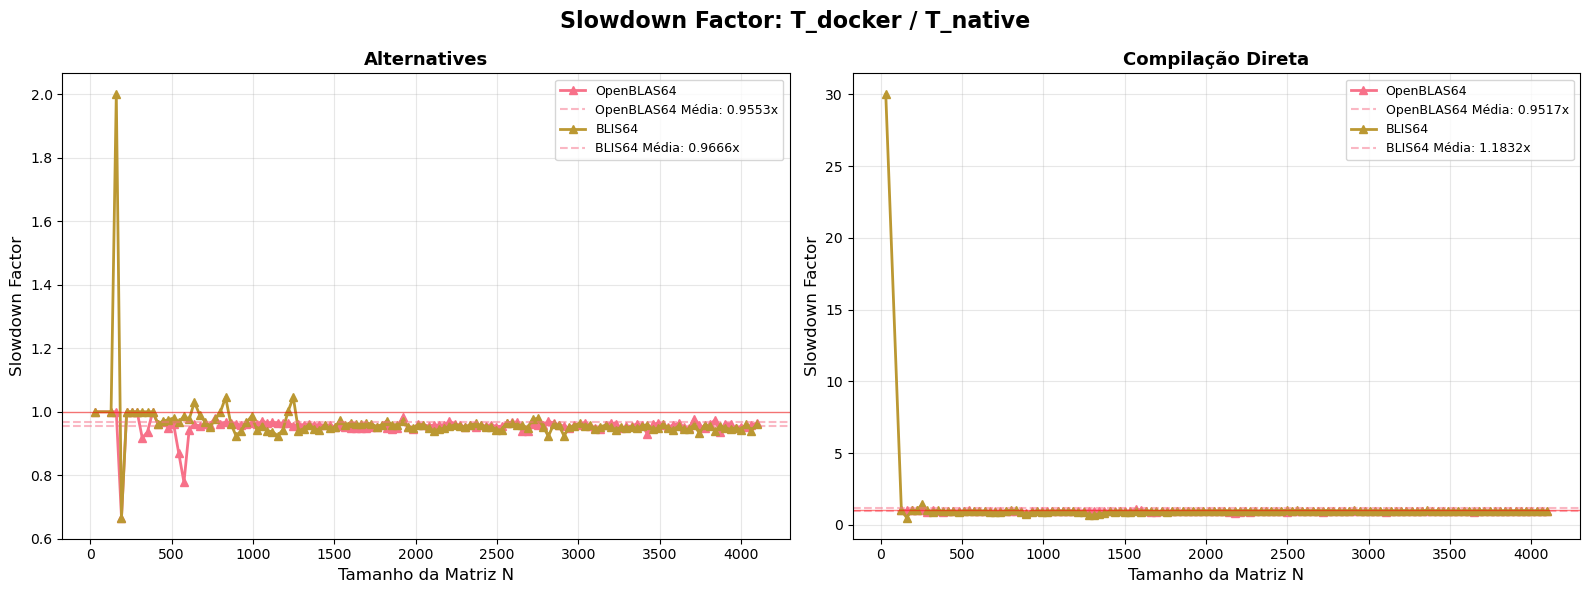

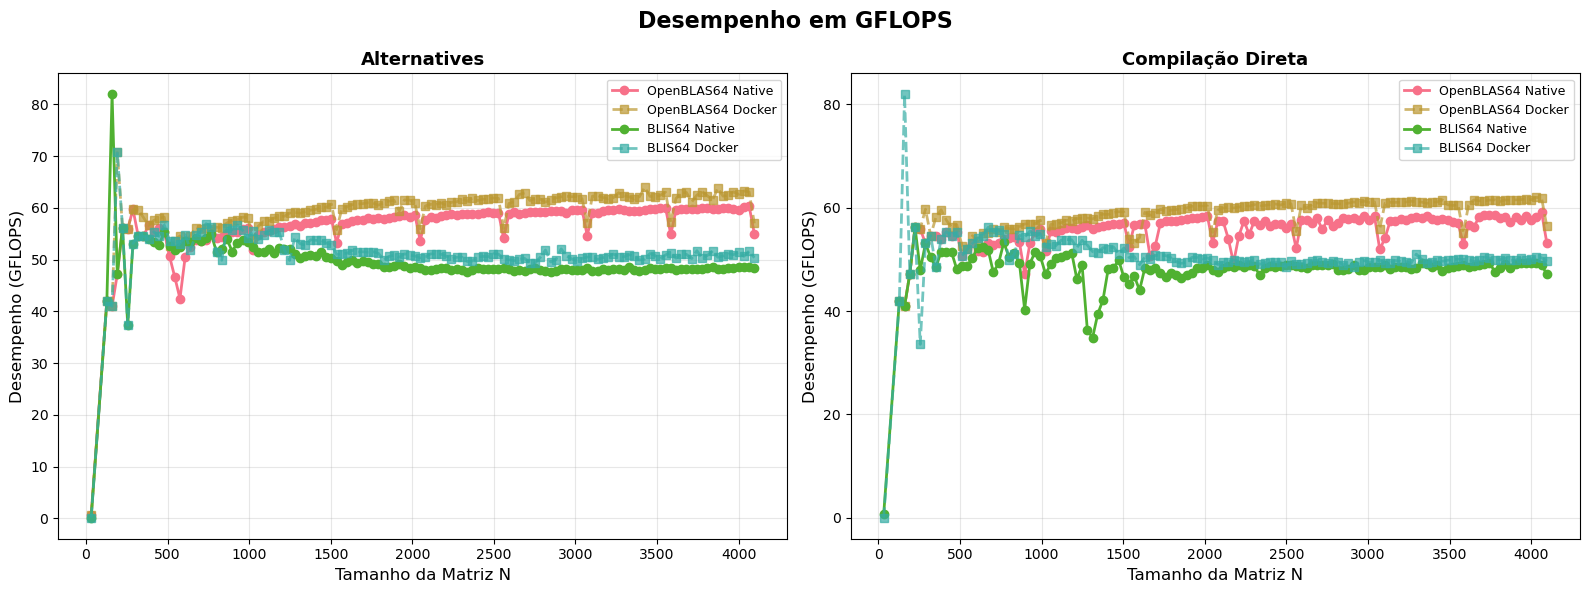

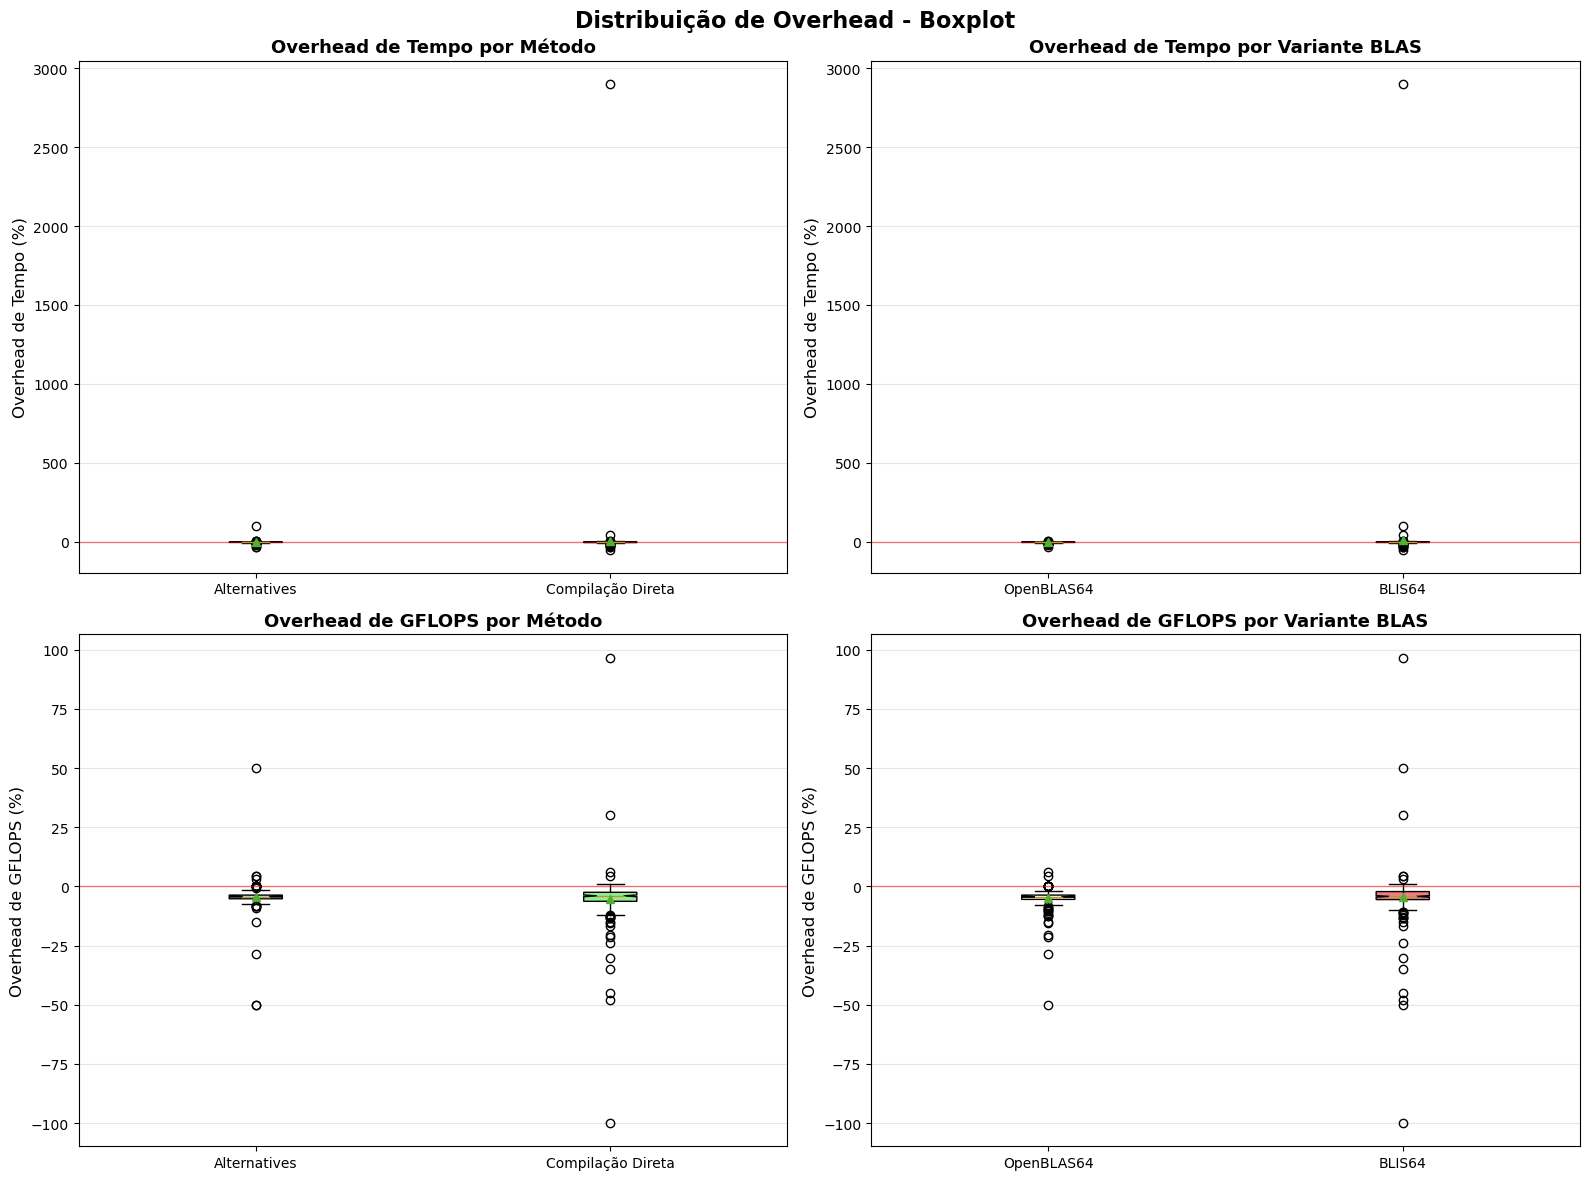


Tabela de Resumo de Overhead:
                               Overhead_Tempo_Mean  Overhead_Tempo_Std  Slowdown_Mean  Overhead_GFLOPS_Mean  Overhead_GFLOPS_Std  Efficiency_Mean
Método             Variante                                                                                                                      
alternatives       OpenBLAS64            -0.044696            0.034238       0.955304             -0.048516             0.049037         1.048516
                   BLIS64                -0.033365            0.098710       0.966635             -0.040720             0.067220         1.040720
direct_compilation OpenBLAS64            -0.048313            0.030841       0.951687             -0.051896             0.035289         1.051896
                   BLIS64                 0.183156            2.588985       1.183156             -0.050808             0.148243         1.050808

✓ Tabelas salvas em ../tabelas/
✓ Gráficos salvos em ../figuras/


In [52]:
# Gerar tabelas e gráficos para visualização dos resultados
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100

# Criar diretórios
Path('../figuras').mkdir(exist_ok=True)
Path('../tabelas').mkdir(exist_ok=True)

# Filtrar dados válidos antes de calcular estatísticas
df_pivot_valid = df_pivot[
    (df_pivot['native'].notna()) & 
    (df_pivot['docker'].notna()) &
    (df_pivot['native'] > 0) &
    (df_pivot['docker'] > 0) &
    (np.isfinite(df_pivot['overhead_tempo'])) &
    (np.isfinite(df_pivot['overhead_gflops']))
].copy()

print(f"\n📊 Dados válidos para análise: {len(df_pivot_valid)} de {len(df_pivot)} registros")

# Calcular estatísticas de overhead por método
print("\n" + "="*80)
print("ESTATÍSTICAS DE OVERHEAD")
print("="*80)

overhead_stats = []
for method in methods:
    for variant in variants:
        mask = (df_pivot_valid['variant'] == variant) & (df_pivot_valid['method'] == method)
        data = df_pivot_valid[mask].copy()
        
        if not data.empty:
            # Estatísticas de overhead de tempo
            mean_overhead_tempo = data['overhead_tempo'].mean()
            std_overhead_tempo = data['overhead_tempo'].std()
            mean_slowdown = data['slowdown'].mean()
            
            # Estatísticas de overhead de GFLOPS
            mean_overhead_gflops = data['overhead_gflops'].mean()
            std_overhead_gflops = data['overhead_gflops'].std()
            mean_efficiency = data['efficiency'].mean()
            
            overhead_stats.append({
                'Método': method,
                'Variante': variant,
                'Overhead_Tempo_Mean': mean_overhead_tempo,
                'Overhead_Tempo_Std': std_overhead_tempo,
                'Slowdown_Mean': mean_slowdown,
                'Overhead_GFLOPS_Mean': mean_overhead_gflops,
                'Overhead_GFLOPS_Std': std_overhead_gflops,
                'Efficiency_Mean': mean_efficiency
            })
            
            method_name = 'Alternatives' if method == 'alternatives' else 'Compilação Direta'
            print(f"\n{method_name} - {variant}:")
            print(f"  Overhead Tempo:  Média = {mean_overhead_tempo:+.6f} ({mean_overhead_tempo*100:+.3f}%), Desvio = {std_overhead_tempo:.6f} ({std_overhead_tempo*100:.3f}%)")
            print(f"  Slowdown Factor: Média = {mean_slowdown:.6f}x")
            print(f"  Overhead GFLOPS: Média = {mean_overhead_gflops:+.6f} ({mean_overhead_gflops*100:+.3f}%), Desvio = {std_overhead_gflops:.6f} ({std_overhead_gflops*100:.3f}%)")
            print(f"  Eficiência:      Média = {mean_efficiency:.6f} ({mean_efficiency*100:.2f}%)")

# Converter para DataFrame
overhead_stats = pd.DataFrame(overhead_stats)
print("\n" + "="*80)

# Gráfico 1: Overhead de Tempo vs Tamanho da Matriz
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Overhead de Tempo: (T_docker - T_native) / T_native', fontsize=16, fontweight='bold')

for idx, method in enumerate(methods):
    ax = axes[idx]
    for variant in variants:
        mask = (df_pivot_valid['variant'] == variant) & (df_pivot_valid['method'] == method)
        data = df_pivot_valid[mask].sort_values('matSize')
        
        if not data.empty:
            # Plotar overhead vs tamanho da matriz
            ax.plot(data['matSize'], data['overhead_tempo'] * 100, 
                    marker='o', label=variant, linewidth=2, markersize=6)
            
            # Calcular e plotar média
            mean_val = data['overhead_tempo'].mean() * 100
            ax.axhline(y=mean_val, linestyle='--', alpha=0.5, 
                       label=f'{variant} Média: {mean_val:+.3f}%')
    
    method_title = 'Alternatives' if method == 'alternatives' else 'Compilação Direta'
    ax.set_xlabel('Tamanho da Matriz N', fontsize=12)
    ax.set_ylabel('Overhead de Tempo (%)', fontsize=12)
    ax.set_title(f'{method_title}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    ax.axhline(y=0, color='red', linestyle='-', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.savefig('../figuras/overhead_tempo.png', dpi=300, bbox_inches='tight')
plt.show()

# Gráfico 2: Overhead de GFLOPS vs Tamanho da Matriz
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Overhead de GFLOPS: (GFLOPS_native - GFLOPS_docker) / GFLOPS_native', 
             fontsize=16, fontweight='bold')

for idx, method in enumerate(methods):
    ax = axes[idx]
    for variant in variants:
        mask = (df_pivot_valid['variant'] == variant) & (df_pivot_valid['method'] == method)
        data = df_pivot_valid[mask].sort_values('matSize')
        
        if not data.empty:
            # Plotar overhead vs tamanho da matriz
            ax.plot(data['matSize'], data['overhead_gflops'] * 100,
                    marker='s', label=variant, linewidth=2, markersize=6)
            
            # Calcular e plotar média
            mean_val = data['overhead_gflops'].mean() * 100
            ax.axhline(y=mean_val, linestyle='--', alpha=0.5,
                       label=f'{variant} Média: {mean_val:+.3f}%')
    
    method_title = 'Alternatives' if method == 'alternatives' else 'Compilação Direta'
    ax.set_xlabel('Tamanho da Matriz N', fontsize=12)
    ax.set_ylabel('Overhead de GFLOPS (%)', fontsize=12)
    ax.set_title(f'{method_title}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    ax.axhline(y=0, color='red', linestyle='-', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.savefig('../figuras/overhead_gflops.png', dpi=300, bbox_inches='tight')
plt.show()

# Gráfico 3: Slowdown Factor vs Tamanho da Matriz
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Slowdown Factor: T_docker / T_native', fontsize=16, fontweight='bold')

for idx, method in enumerate(methods):
    ax = axes[idx]
    for variant in variants:
        mask = (df_pivot_valid['variant'] == variant) & (df_pivot_valid['method'] == method)
        data = df_pivot_valid[mask].sort_values('matSize')
        
        if not data.empty:
            ax.plot(data['matSize'], data['slowdown'],
                    marker='^', label=variant, linewidth=2, markersize=6)
            
            mean_val = data['slowdown'].mean()
            ax.axhline(y=mean_val, linestyle='--', alpha=0.5,
                       label=f'{variant} Média: {mean_val:.4f}x')
    
    method_title = 'Alternatives' if method == 'alternatives' else 'Compilação Direta'
    ax.set_xlabel('Tamanho da Matriz N', fontsize=12)
    ax.set_ylabel('Slowdown Factor', fontsize=12)
    ax.set_title(f'{method_title}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    ax.axhline(y=1.0, color='red', linestyle='-', alpha=0.5, linewidth=1, 
               label='Referência (1.0 = equivalente)')

plt.tight_layout()
plt.savefig('../figuras/slowdown_factor.png', dpi=300, bbox_inches='tight')
plt.show()

# Gráfico 4: Comparação de Desempenho em GFLOPS
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Desempenho em GFLOPS', fontsize=16, fontweight='bold')

for idx, method in enumerate(methods):
    ax = axes[idx]
    for variant in variants:
        mask = (df_pivot_valid['variant'] == variant) & (df_pivot_valid['method'] == method)
        data = df_pivot_valid[mask].sort_values('matSize')
        
        if not data.empty:
            ax.plot(data['matSize'], data['gflops_native'], marker='o',
                    label=f'{variant} Native', linewidth=2)
            ax.plot(data['matSize'], data['gflops_docker'], marker='s',
                    label=f'{variant} Docker', linewidth=2, linestyle='--', alpha=0.7)
    
    method_title = 'Alternatives' if method == 'alternatives' else 'Compilação Direta'
    ax.set_xlabel('Tamanho da Matriz N', fontsize=12)
    ax.set_ylabel('Desempenho (GFLOPS)', fontsize=12)
    ax.set_title(f'{method_title}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig('../figuras/desempenho_gflops.png', dpi=300, bbox_inches='tight')
plt.show()

# Gráfico 5: Boxplot de Overhead
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribuição de Overhead - Boxplot', fontsize=16, fontweight='bold')

# Boxplot 1: Overhead de Tempo por Método
ax = axes[0, 0]
boxplot_data_tempo_method = [df_pivot_valid[df_pivot_valid['method'] == method]['overhead_tempo'] * 100 
                              for method in methods]
bp1 = ax.boxplot(boxplot_data_tempo_method, labels=['Alternatives', 'Compilação Direta'],
                 patch_artist=True, notch=True, showmeans=True)
for patch, color in zip(bp1['boxes'], ['lightblue', 'lightgreen']):
    patch.set_facecolor(color)
ax.set_ylabel('Overhead de Tempo (%)', fontsize=12)
ax.set_title('Overhead de Tempo por Método', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='red', linestyle='-', alpha=0.5, linewidth=1)

# Boxplot 2: Overhead de Tempo por Variante
ax = axes[0, 1]
boxplot_data_tempo_variant = [df_pivot_valid[df_pivot_valid['variant'] == variant]['overhead_tempo'] * 100 
                               for variant in variants]
bp2 = ax.boxplot(boxplot_data_tempo_variant, labels=variants,
                 patch_artist=True, notch=True, showmeans=True)
for patch, color in zip(bp2['boxes'], ['lightyellow', 'lightcoral']):
    patch.set_facecolor(color)
ax.set_ylabel('Overhead de Tempo (%)', fontsize=12)
ax.set_title('Overhead de Tempo por Variante BLAS', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='red', linestyle='-', alpha=0.5, linewidth=1)

# Boxplot 3: Overhead de GFLOPS por Método
ax = axes[1, 0]
boxplot_data_gflops_method = [df_pivot_valid[df_pivot_valid['method'] == method]['overhead_gflops'] * 100 
                              for method in methods]
bp3 = ax.boxplot(boxplot_data_gflops_method, labels=['Alternatives', 'Compilação Direta'],
                 patch_artist=True, notch=True, showmeans=True)
for patch, color in zip(bp3['boxes'], ['lightblue', 'lightgreen']):
    patch.set_facecolor(color)
ax.set_ylabel('Overhead de GFLOPS (%)', fontsize=12)
ax.set_title('Overhead de GFLOPS por Método', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='red', linestyle='-', alpha=0.5, linewidth=1)

# Boxplot 4: Overhead de GFLOPS por Variante
ax = axes[1, 1]
boxplot_data_gflops_variant = [df_pivot_valid[df_pivot_valid['variant'] == variant]['overhead_gflops'] * 100 
                               for variant in variants]
bp4 = ax.boxplot(boxplot_data_gflops_variant, labels=variants,
                 patch_artist=True, notch=True, showmeans=True)
for patch, color in zip(bp4['boxes'], ['lightyellow', 'lightcoral']):
    patch.set_facecolor(color)
ax.set_ylabel('Overhead de GFLOPS (%)', fontsize=12)
ax.set_title('Overhead de GFLOPS por Variante BLAS', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='red', linestyle='-', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.savefig('../figuras/overhead_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

# Tabela de resumo
summary_table = overhead_stats.set_index(['Método', 'Variante'])

print("\n" + "="*80)
print("Tabela de Resumo de Overhead:")
print("="*80)
print(summary_table.to_string())

# Salvar tabelas
summary_table.to_csv('../tabelas/resumo_overhead.csv')
summary_table.to_latex('../tabelas/resumo_overhead.tex', float_format="%.6f")
print("\n✓ Tabelas salvas em ../tabelas/")
print("✓ Gráficos salvos em ../figuras/")


## 6. Conclusões Possíveis

Com base nessa metodologia, é possível responder a questões como:

- Existe overhead mensurável ao usar Docker para aplicações de alto desempenho baseadas em DGEMM?
- Esse overhead depende do tamanho da matriz \( N \)?
- O overhead aumenta ou diminui com o número de *threads*?
- Diferentes implementações de BLAS são mais ou menos sensíveis ao uso de Docker?

A combinação de métricas quantitativas (overhead de tempo e de GFLOPS) com análise estatística confere rigor ao estudo
e permite conclusões bem fundamentadas em um contexto de HPC.


In [53]:
# Sumarizar resultados e gerar artefatos finais para o TCC

# Salvar tabela detalhada
detailed_table = df_pivot[['variant', 'method', 'matSize', 'native', 'docker',
                           'overhead_tempo', 'slowdown', 'gflops_native', 'gflops_docker', 
                           'overhead_gflops', 'efficiency']].copy()
detailed_table.columns = ['BLAS', 'Método', 'N', 'T_native (s)', 'T_docker (s)',
                          'Overhead_tempo', 'Slowdown', 'GFLOPS_native', 'GFLOPS_docker', 
                          'Overhead_GFLOPS', 'Efficiency']

detailed_table.to_csv('../tabelas/resultados_detalhados.csv', index=False, float_format='%.6f')
detailed_table.to_latex('../tabelas/resultados_detalhados.tex', index=False, float_format="%.6f")

# Salvar estatísticas de overhead
overhead_stats.to_csv('../tabelas/estatisticas_overhead.csv', index=False, float_format='%.6f')
overhead_stats.to_latex('../tabelas/estatisticas_overhead.tex', index=False, float_format="%.6f")

# Filtrar dados válidos: remover NaN, inf, e registros com tempo zero
df_pivot_clean = df_pivot[
    (df_pivot['native'].notna()) & 
    (df_pivot['docker'].notna()) &
    (df_pivot['native'] > 0) &
    (df_pivot['docker'] > 0) &
    (np.isfinite(df_pivot['overhead_tempo'])) &
    (np.isfinite(df_pivot['overhead_gflops']))
].copy()

# Verificar se há dados válidos
if len(df_pivot_clean) == 0:
    print("="*80)
    print("⚠️  AVISO: Não há dados válidos para análise!")
    print("="*80)
    print("\nProblemas detectados:")
    print(f"  • Registros com tempo zero: {((df_pivot['native'] == 0) | (df_pivot['docker'] == 0)).sum()}")
    print(f"  • Registros com NaN: {(df_pivot['native'].isna() | df_pivot['docker'].isna()).sum()}")
    print(f"  • Registros com inf: {(~np.isfinite(df_pivot['overhead_tempo'])).sum()}")
    print("\nVerifique os arquivos de dados e execute as células anteriores novamente.")
else:
    # Resumo final
    overall_overhead_tempo = df_pivot_clean['overhead_tempo'].mean()
    overall_overhead_gflops = df_pivot_clean['overhead_gflops'].mean()
    std_overhead_tempo = df_pivot_clean['overhead_tempo'].std()
    std_overhead_gflops = df_pivot_clean['overhead_gflops'].std()
    overall_slowdown = df_pivot_clean['slowdown'].mean()
    overall_efficiency = df_pivot_clean['efficiency'].mean()
    
    print("="*80)
    print("RESUMO FINAL PARA TCC")
    print("="*80)
    print(f"\n📊 MÉTRICAS DE OVERHEAD (Fórmulas Padrão HPC):")
    print(f"\n   Dados analisados: {len(df_pivot_clean)} de {len(df_pivot)} registros")
    print(f"   Registros excluídos: {len(df_pivot) - len(df_pivot_clean)} (zeros, NaN ou inf)")
    print(f"\n   Tempo de Execução:")
    print(f"   • Overhead médio: {overall_overhead_tempo*100:+.3f}% (σ = {std_overhead_tempo*100:.3f}%)")
    print(f"   • Slowdown médio: {overall_slowdown:.4f}x")
    print(f"\n   Desempenho (GFLOPS):")
    print(f"   • Overhead médio: {overall_overhead_gflops*100:+.3f}% (σ = {std_overhead_gflops*100:.3f}%)")
    print(f"   • Eficiência média: {overall_efficiency:.4f} ({overall_efficiency*100:.2f}%)")
    
    # Interpretação dos resultados
    print("\n" + "="*80)
    print("📖 INTERPRETAÇÃO DAS MÉTRICAS:")
    print("="*80)
    print(f"\n   Overhead de Tempo: overhead = (T_docker - T_native) / T_native")
    print(f"   • Valores POSITIVOS: Docker mais LENTO (overhead existe)")
    print(f"   • Valores NEGATIVOS: Docker mais RÁPIDO (improvável)")
    print(f"   • Valores próximos de 0: Desempenho EQUIVALENTE")
    
    print(f"\n   Slowdown Factor: slowdown = T_docker / T_native")
    print(f"   • slowdown > 1.0: Docker mais lento")
    print(f"   • slowdown < 1.0: Docker mais rápido")
    print(f"   • slowdown ≈ 1.0: Equivalente")
    
    print(f"\n   Overhead de GFLOPS: overhead = (GFLOPS_native - GFLOPS_docker) / GFLOPS_native")
    print(f"   • Valores POSITIVOS: Docker tem MENOS desempenho (perda)")
    print(f"   • Valores NEGATIVOS: Docker tem MAIS desempenho (ganho)")
    print(f"   • Valores próximos de 0: Desempenho EQUIVALENTE")
    
    print(f"\n   Eficiência: efficiency = GFLOPS_docker / GFLOPS_native")
    print(f"   • efficiency = 1.0 (100%): Sem perda")
    print(f"   • efficiency = 0.95 (95%): 5% de perda")
    print(f"   • efficiency > 1.0: Docker supera nativo (improvável)")
    
    # Classificação baseada em overhead
    print("\n" + "="*80)
    print("🎯 CLASSIFICAÇÃO DO OVERHEAD:")
    print("="*80)
    
    if abs(overall_overhead_tempo) < 0.01:
        print("\n✅ DESPREZÍVEL (<1%)")
        print("   Docker é RECOMENDADO para desenvolvimento E produção HPC")
        print("   Overhead é estatisticamente insignificante")
    elif abs(overall_overhead_tempo) < 0.03:
        print("\n✅ ACEITÁVEL (<3%)")
        print("   Docker é VIÁVEL para desenvolvimento, testes e produção")
        print("   Overhead baixo, compensado pelos benefícios de containerização")
    elif abs(overall_overhead_tempo) < 0.05:
        print("\n⚠️  PEQUENO (3-5%)")
        print("   Docker é adequado para desenvolvimento e testes")
        print("   Para produção HPC crítica, avaliar caso a caso")
    else:
        print("\n❌ SIGNIFICATIVO (≥5%)")
        print("   Docker deve ser usado com cautela em produção HPC")
        print("   Recomenda-se ambiente nativo para aplicações críticas")
    
    print("\n" + "="*80)
    print("📁 ARTEFATOS GERADOS:")
    print("="*80)
    print("\n   📊 Figuras (../figuras/):")
    print("     • overhead_tempo.png - Overhead de tempo vs tamanho da matriz")
    print("     • overhead_gflops.png - Overhead de GFLOPS vs tamanho da matriz")
    print("     • slowdown_factor.png - Fator de slowdown vs tamanho da matriz")
    print("     • desempenho_gflops.png - Comparação direta Native vs Docker")
    print("\n   📋 Tabelas (../tabelas/):")
    print("     • resumo_overhead.csv/.tex - Estatísticas agregadas")
    print("     • resultados_detalhados.csv/.tex - Dados completos")
    print("     • estatisticas_overhead.csv/.tex - Médias e desvios padrão")
    print("\n" + "="*80)

RESUMO FINAL PARA TCC

📊 MÉTRICAS DE OVERHEAD (Fórmulas Padrão HPC):

   Dados analisados: 503 de 512 registros
   Registros excluídos: 9 (zeros, NaN ou inf)

   Tempo de Execução:
   • Overhead médio: +1.432% (σ = 129.675%)
   • Slowdown médio: 1.0143x

   Desempenho (GFLOPS):
   • Overhead médio: -4.798% (σ = 8.673%)
   • Eficiência média: 1.0480 (104.80%)

📖 INTERPRETAÇÃO DAS MÉTRICAS:

   Overhead de Tempo: overhead = (T_docker - T_native) / T_native
   • Valores POSITIVOS: Docker mais LENTO (overhead existe)
   • Valores NEGATIVOS: Docker mais RÁPIDO (improvável)
   • Valores próximos de 0: Desempenho EQUIVALENTE

   Slowdown Factor: slowdown = T_docker / T_native
   • slowdown > 1.0: Docker mais lento
   • slowdown < 1.0: Docker mais rápido
   • slowdown ≈ 1.0: Equivalente

   Overhead de GFLOPS: overhead = (GFLOPS_native - GFLOPS_docker) / GFLOPS_native
   • Valores POSITIVOS: Docker tem MENOS desempenho (perda)
   • Valores NEGATIVOS: Docker tem MAIS desempenho (ganho)
   • Val